In [45]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
train_dir=r"C:\Users\OFFICE\Desktop\Revature\X-ray image Classification\chest_xray\train"
test_dir=r"C:\Users\OFFICE\Desktop\Revature\X-ray image Classification\chest_xray\test"
val_dir=r"C:\Users\OFFICE\Desktop\Revature\X-ray image Classification\chest_xray\val"

In [47]:
# All images will be rescaled by 1./255 and transformed
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [48]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [50]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [51]:
# Load images in batches from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2254 images belonging to 2 classes.


In [52]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 241 images belonging to 2 classes.


In [53]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [54]:
# Load ResNet50 pre-trained model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [55]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [56]:
# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

In [57]:
# Model finalization
model = Model(inputs=base_model.input, outputs=predictions)

In [58]:
# Compile model
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5


C:\Users\OFFICE\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.6544 - loss: 0.6829 - val_accuracy: 0.5625 - val_loss: 0.6424
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.7530 - loss: 0.5063 - val_accuracy: 0.6250 - val_loss: 0.5871
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.7453 - loss: 0.5681 - val_accuracy: 0.5625 - val_loss: 0.8007
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.7512 - loss: 0.5037 - val_accuracy: 0.5625 - val_loss: 0.8052
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.7659 - loss: 0.4584 - val_accuracy: 0.5625 - val_loss: 0.7422


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

In [61]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

C:\Users\OFFICE\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7678 - loss: 0.4452
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step


In [62]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 17  76]
 [ 30 118]]


In [63]:
# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred > 0.5))

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.18      0.24        93
           1       0.61      0.80      0.69       148

    accuracy                           0.56       241
   macro avg       0.48      0.49      0.47       241
weighted avg       0.51      0.56      0.52       241



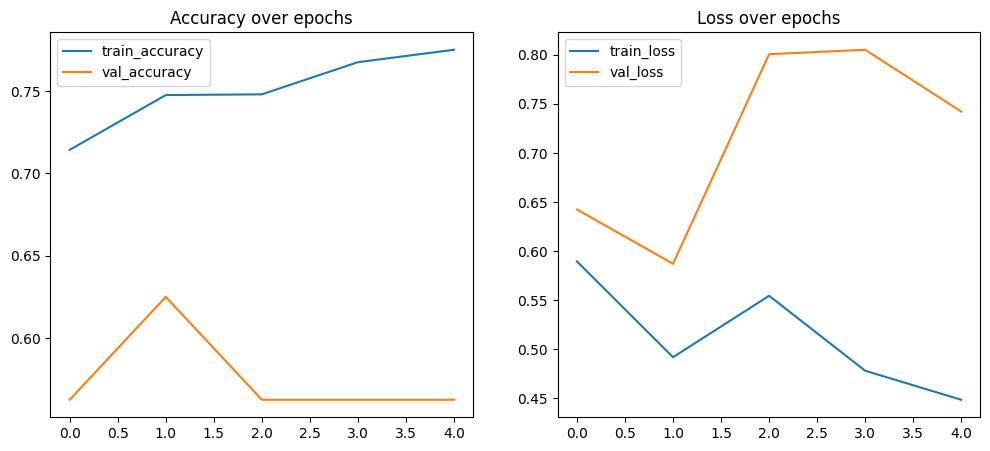

In [64]:
# Plotting accuracy and loss
def plot_performance(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.show()

plot_performance(history)